In [375]:
!python /mnt/External/8TBHDD/AAG/EDA/Data_preparatiom/data_preprocess.py \
--files /mnt/External/8TBHDD/AAG/EDA/Data_preparatiom/B/2019_B_combined.csv \
/mnt/External/8TBHDD/AAG/EDA/Data_preparatiom/B/2020_B_combined.csv \
/mnt/External/8TBHDD/AAG/EDA/Data_preparatiom/B/2021_B_combined.csv \
--output_path /mnt/External/8TBHDD/AAG/EDA/final_datasets

In [376]:
num_weeks=3

In [377]:
!pip install xgboost
!pip install lightgbm
!pip install catboost
!pip install torch torchvision torchaudio

In [378]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import random
from tqdm import tqdm

# Data Preparation

In [379]:
def select_feasible(group):
    """
    Select the most feasible row based on the 't_kWh' value in a group.
    Criteria: Closest to the median of the group.
    """
    # Calculate the median of the t_kWh column
    median = group['t_kWh'].median()
    
    # Find the row with the t_kWh value closest to the median
    feasible_row = group.loc[(group['t_kWh'] - median).abs().idxmin()]
    return feasible_row


/tmp/ipykernel_1109064/296022092.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_new = df.groupby('date').apply(select_feasible).reset_index(drop=True)
/tmp/ipykernel_1109064/296022092.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['day_of_week'] = df_new['day_of_week']
/tmp/ipykernel_1109064/296022092.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

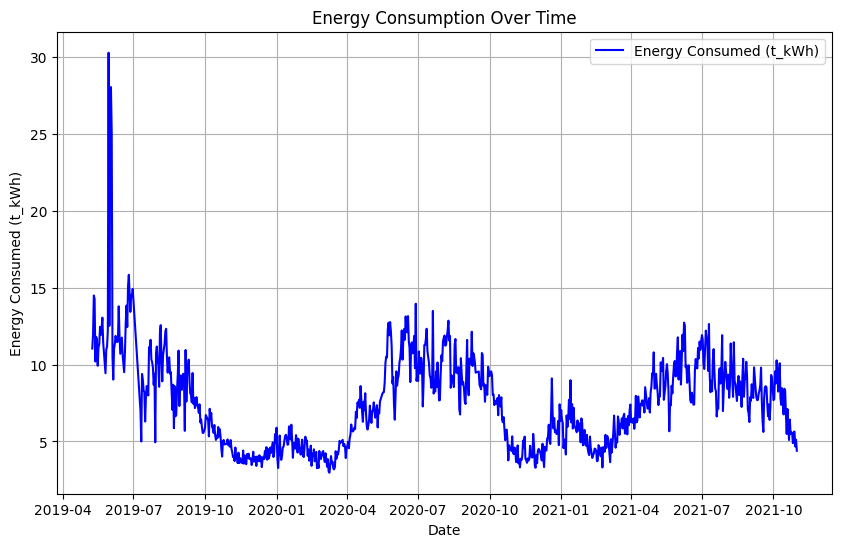

In [380]:
# Load dataset and parse dates
df = pd.read_csv('/mnt/External/8TBHDD/AAG/EDA/final_datasets/city_data.csv', parse_dates=['date'])

# # List of unwanted columns to drop
# unwanted_columns = ["precip","snow", "snowdepth", "windgust", "visibility", "solarradiation", 
#     "solarenergy", "uvindex", "Rain", "Fog", "Clear", "Overcast", 
#     "Partially cloudy", "preciptype_rain", "unique_id"
# ]

# List of unwanted columns to drop
unwanted_columns = ["precip","snow", "snowdepth", "windgust", "visibility", "solarradiation", 
    "solarenergy", "uvindex", "Rain", "Clear", "Overcast", 
    "Partially cloudy", "preciptype_rain", "unique_id"
]

# Drop unwanted columns
df = df.drop(columns=unwanted_columns)

# Drop columns with all zero values
df = df.loc[:, (df != 0).any(axis=0)]

#print(df.columns.tolist())



# Group by 'date' and apply the custom function
df_new = df.groupby('date').apply(select_feasible).reset_index(drop=True)

#df_new = df.groupby('date', as_index=False).mean()

# # Remove duplicates based on date
# df_new = df.drop_duplicates(subset='date', keep='first').reset_index(drop=True)

# Ensure the date column is in datetime format
df_new['date'] = pd.to_datetime(df_new['date'])

# Sort by date
df_new = df_new.sort_values(by='date').reset_index(drop=True)

# Dynamically extract remaining feature columns (exclude 'date' and 't_kWh')
feature_columns = [col for col in df_new.columns if col not in ['date', 't_kWh']]

# Extract features
features = df_new[feature_columns]

target = df_new['t_kWh']
dates = df_new['date']

# Add date features (optional)
df_new['day_of_week'] = df_new['date'].dt.dayofweek
df_new['month'] = df_new['date'].dt.month
df_new['day'] = df_new['date'].dt.day
features['day_of_week'] = df_new['day_of_week']
features['month'] = df_new['month']
features['day'] = df_new['day']

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_new['date'], df_new['t_kWh'], label='Energy Consumed (t_kWh)', color='blue')
plt.xlabel('Date')
plt.ylabel('Energy Consumed (t_kWh)')
plt.title('Energy Consumption Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Train Test Split

In [381]:
# Ensure dates is a pandas DatetimeIndex or convert it to datetime
dates = pd.to_datetime(dates)

# Combine features, target, and dates into a single DataFrame
data = pd.DataFrame(features)
data['target'] = target
data['date'] = dates

# Specify columns for which to create lag features
lag_columns = ['z_Avg Voltage (Volt)', 'z_Avg Current (Amp)', 'y_Freq (Hz)']

# Create 1-day lag features
for col in lag_columns:
    data[f'lag1_{col}'] = data[col].shift(1)
    data[f'lag2_{col}'] = data[col].shift(2)
    data[f'lag3_{col}'] = data[col].shift(3)

# Drop rows with NaN values created by the lag (first row will have NaN lag features)
data.dropna(inplace=True)

# Determine the start date of the last 3 weeks
last_date = data['date'].max()
start_test_date = last_date - pd.Timedelta(weeks=num_weeks)  + pd.Timedelta(days=1)

# Filter the last 3 weeks for the test set
test_data = data[data['date'] >= start_test_date]

# Remaining data will be the training set
train_data = data[data['date'] < start_test_date]

# Separate features, targets, and dates for train and test sets
X_test = test_data.drop(columns=['target', 'date'])
y_test = test_data['target']
dates_test = test_data['date']

X_train = train_data.drop(columns=['target', 'date'])
y_train = train_data['target']
dates_train = train_data['date']

X_train=X_train.drop(columns=['z_Avg Voltage (Volt)','z_Avg Current (Amp)','y_Freq (Hz)'])
X_test=X_test.drop(columns=['z_Avg Voltage (Volt)','z_Avg Current (Amp)','y_Freq (Hz)'])

# Check the resulting splits
print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")


Training data: (861, 32), (861,)
Testing data: (21, 32), (21,)


# Metrics

In [382]:
def metrics(y_train,y_test, y_train_pred,y_test_pred):
    # Calculate metrics for training data
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Calculate metrics for testing data
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print metrics in a tabular format
    print(f"{'Metric':<12}{'Train':<12}{'Test':<12}")
    print(f"{'-'*36}")
    print(f"{'RMSE':<12}{train_rmse:<12.4f}{test_rmse:<12.4f}")
    print(f"{'MAE':<12}{train_mae:<12.4f}{test_mae:<12.4f}")
    print(f"{'R2':<12}{train_r2:<12.4f}{test_r2:<12.4f}")

In [383]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def table_and_plots(dates_test, y_test, y_test_pred):

    y_test_pred = pd.Series(y_test_pred, index=y_test.index)
    # Ensure dates_test is a pandas DatetimeIndex or converted to datetime
    dates_test = pd.to_datetime(dates_test)

    # Extract the day of the week as day names from dates_test
    day_of_week = dates_test.dt.day_name()

    # Convert y_test_pred (if it is a NumPy array) to a pandas Series with the same index as y_test
    if isinstance(y_test_pred, np.ndarray):
        y_test_pred = pd.Series(y_test_pred, index=y_test.index)

    # Combine predictions and true values for analysis
    results_df = pd.DataFrame({
        'date': dates_test,
        'actual': y_test,
        'predicted': y_test_pred,
        'day_of_week': day_of_week
    })

    # Calculate average load predictions for each day of the week
    avg_load_per_day = results_df.groupby('day_of_week')[['actual', 'predicted']].mean()
    avg_load_per_day.rename(columns={'actual': 'Actual Avg Load', 'predicted': 'Predicted Avg Load'}, inplace=True)

    # Function to calculate Mean Absolute Percentage Error (MAPE)
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate metrics for each day of the week
    metrics_per_day = results_df.groupby('day_of_week').apply(
        lambda group: pd.Series({
            'RMSE': np.sqrt(mean_squared_error(group['actual'], group['predicted'])),
            'MAE': mean_absolute_error(group['actual'], group['predicted']),
            'MAPE': mean_absolute_percentage_error(group['actual'], group['predicted'])
        })
    )

    # Merge average load with metrics
    avg_load_per_day_metrics = avg_load_per_day.merge(metrics_per_day, left_index=True, right_index=True)

    # Sort index to ensure days are in the correct order
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    avg_load_per_day_metrics = avg_load_per_day_metrics.reindex(day_order)

    # Print the result in a clear format
    print("Average Load Per Day with Metrics:")
    print(avg_load_per_day_metrics.to_string())

    # Plot average load per day of the week
    plt.figure(figsize=(10, 6))
    avg_load_per_day_metrics[['Actual Avg Load', 'Predicted Avg Load']].plot(kind='bar', grid=True, ax=plt.gca())
    plt.xlabel('Day of the Week')
    plt.ylabel('t_kWh')
    plt.title('Average Load Per Day of the Week')
    plt.xticks(rotation=45)
    plt.legend(title='Load Type', loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have already loaded your data)
# table_and_plots(dates_test, y_test, y_test_pred)


# XGBoost

Metric      Train       Test        
------------------------------------
RMSE        0.2059      0.7656      
MAE         0.1476      0.6519      
R2          0.9954      0.6093      


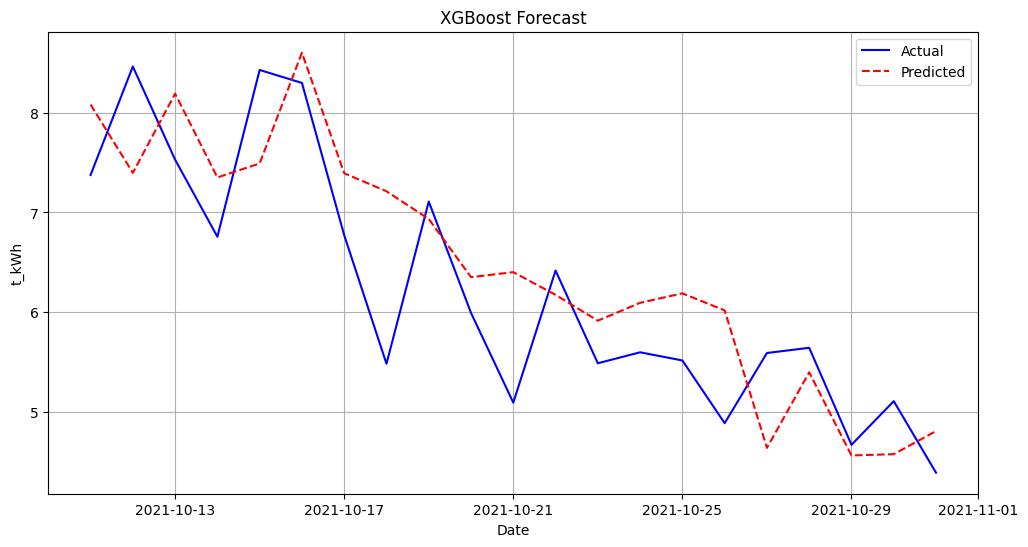

In [384]:
# Train XGBoost model
model = XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=10, random_state=42, reg_alpha=0.1, reg_lambda=0.1)
model.fit(X_train, y_train)

# Predictions on training data
y_train_pred = model.predict(X_train)

# Predictions on testing data
y_test_pred = model.predict(X_test)

metrics(y_train, y_test, y_train_pred,y_test_pred)


# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, y_test_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('t_kWh')
plt.title('XGBoost Forecast')
plt.legend()
plt.grid(True)
plt.show()


Average Load Per Day with Metrics:
             Actual Avg Load  Predicted Avg Load      RMSE       MAE       MAPE
day_of_week                                                                    
Monday              6.124000            7.160734  1.146873  1.036734  17.783933
Tuesday             6.819667            6.782944  0.903463  0.791006  12.739734
Wednesday           6.370333            6.393522  0.700725  0.657621  10.603661
Thursday            5.830000            6.382547  0.842017  0.716442  12.954163
Friday              6.505000            6.075614  0.562691  0.429386   5.736763
Saturday            6.297667            6.363728  0.430970  0.420689   7.283757
Sunday              5.586000            6.097582  0.518380  0.511582   9.183251


/tmp/ipykernel_1109064/964526536.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_day = results_df.groupby('day_of_week').apply(


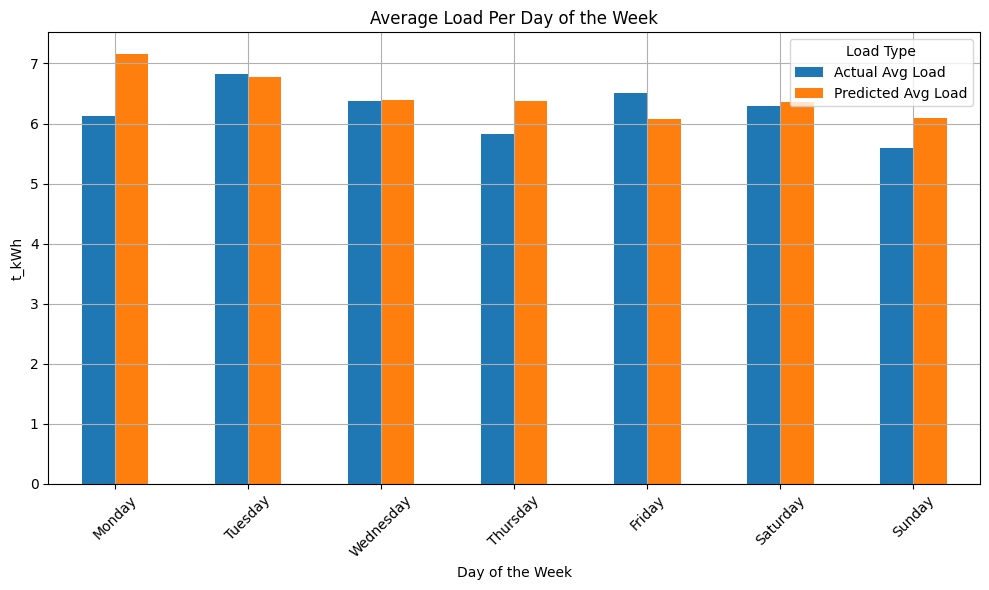

In [385]:
table_and_plots(dates_test,y_test,y_test_pred)
y_test_pred_xg=y_test_pred

# LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5798
[LightGBM] [Info] Number of data points in the train set: 861, number of used features: 31
[LightGBM] [Info] Start training from score 7.484733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

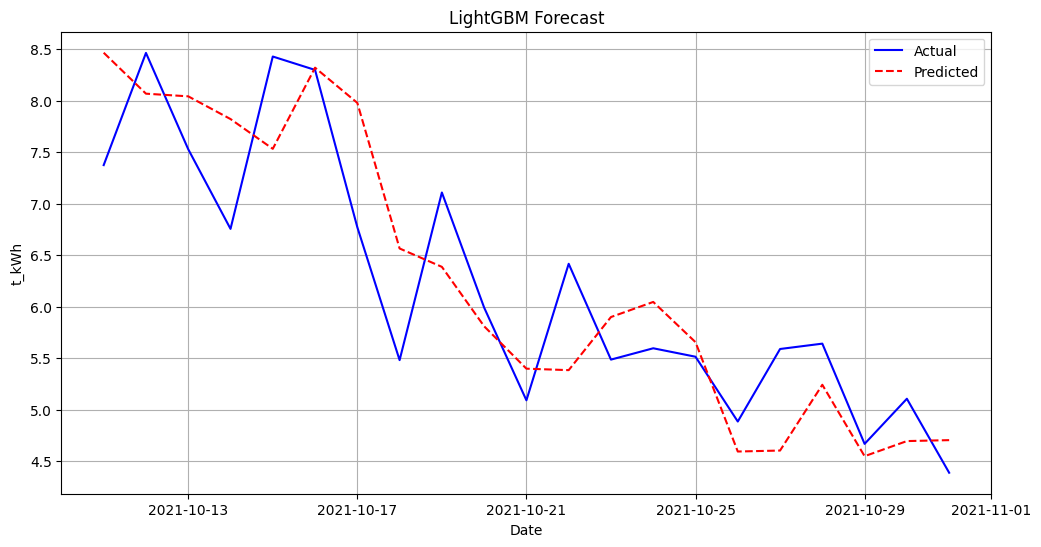

In [386]:
# Initialize the LightGBM model
lgb_model = LGBMRegressor(
    n_estimators=2000,          # Number of boosting rounds
    learning_rate=0.01,        # Learning rate
    max_depth=50,              # Maximum depth of trees
    random_state=42,           # Random seed for reproducibility
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=0.1             # L2 regularization
)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

metrics(y_train, y_test, y_train_pred,y_test_pred)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, y_test_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('t_kWh')
plt.title('LightGBM Forecast')
plt.legend()
plt.grid(True)
plt.show()


Average Load Per Day with Metrics:
             Actual Avg Load  Predicted Avg Load      RMSE       MAE       MAPE
day_of_week                                                                    
Monday              6.124000            6.895957  0.891522  0.771957  12.373855
Tuesday             6.819667            6.350211  0.503987  0.469456   6.927833
Wednesday           6.370333            6.152426  0.650240  0.560273   9.161515
Thursday            5.830000            6.154618  0.680774  0.590820   9.629132
Friday              6.505000            5.822428  0.792157  0.682572   9.758504
Saturday            6.297667            6.305754  0.336676  0.281985   5.279879
Sunday              5.586000            6.243685  0.765773  0.657685  11.021850


/tmp/ipykernel_1109064/964526536.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_day = results_df.groupby('day_of_week').apply(


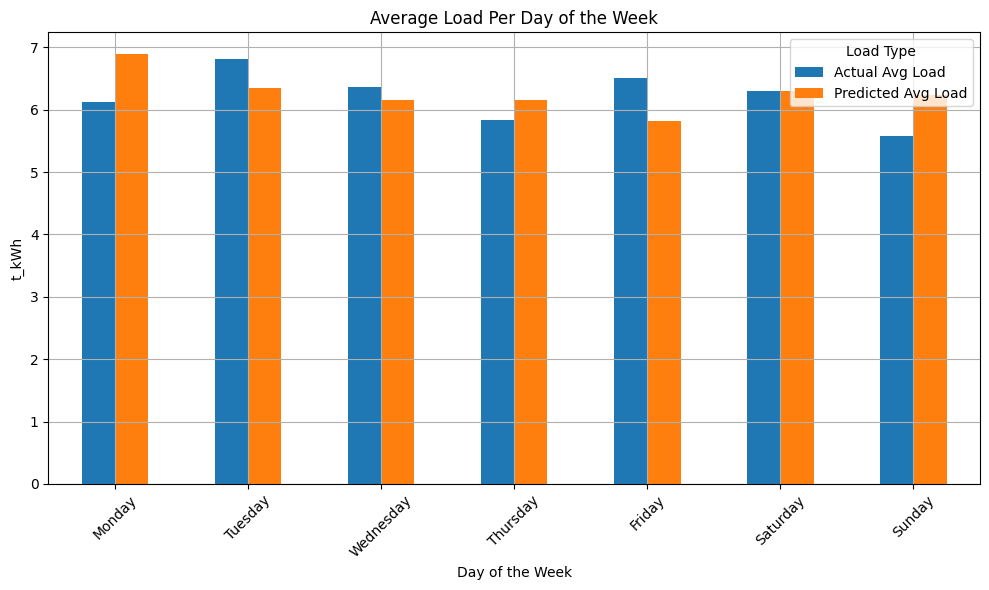

In [387]:
table_and_plots(dates_test,y_test,y_test_pred)
y_test_pred_lightgbm=y_test_pred

# Catboost

0:	learn: 3.0223053	total: 15.2ms	remaining: 7.58s
100:	learn: 1.7992304	total: 1.54s	remaining: 6.08s
200:	learn: 1.2616662	total: 3.06s	remaining: 4.55s
300:	learn: 0.9781772	total: 4.58s	remaining: 3.03s
400:	learn: 0.8076994	total: 6.08s	remaining: 1.5s
499:	learn: 0.6925877	total: 7.62s	remaining: 0us
Metric      Train       Test        
------------------------------------
RMSE        0.6926      0.7601      
MAE         0.4985      0.6015      
R2          0.9481      0.6149      


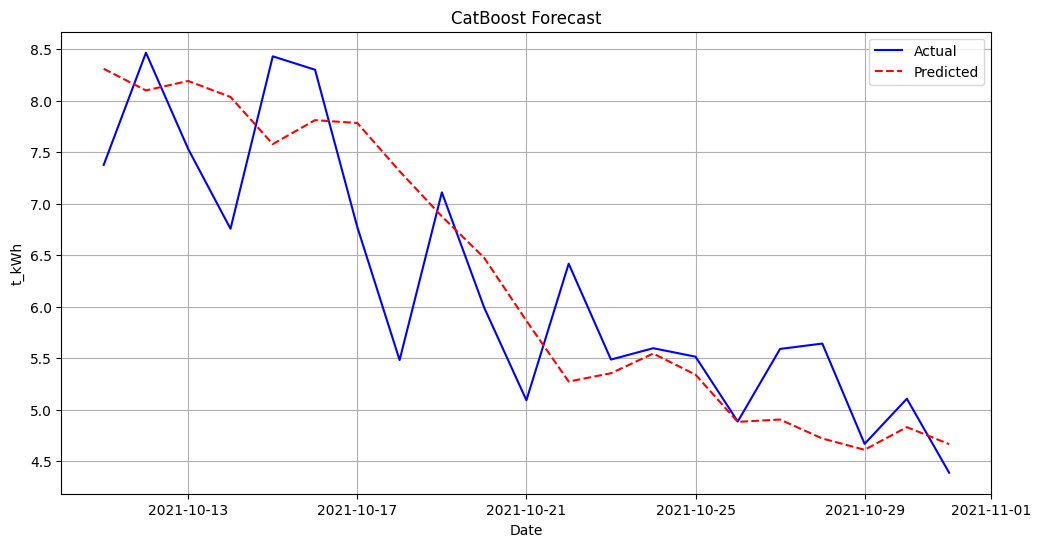

In [388]:
# Initialize the CatBoost model
cat_model = CatBoostRegressor(
    iterations=500,          # Number of boosting rounds
    learning_rate=0.01,      # Learning rate
    depth=10,                # Maximum depth of trees
    random_seed=42,          # Random seed for reproducibility
    l2_leaf_reg=3.0,         # L2 regularization
    verbose=100              # Print progress every 100 iterations
)

# Train the model
cat_model.fit(X_train, y_train)

# Make predictions
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

metrics(y_train, y_test, y_train_pred,y_test_pred)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, y_test_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('t_kWh')
plt.title('CatBoost Forecast')
plt.legend()
plt.grid(True)
plt.show()


Average Load Per Day with Metrics:
             Actual Avg Load  Predicted Avg Load      RMSE       MAE       MAPE
day_of_week                                                                    
Monday              6.124000            6.987764  1.191510  0.979948  16.413168
Tuesday             6.819667            6.618864  0.250470  0.200803   2.557290
Wednesday           6.370333            6.523206  0.616161  0.609508   9.695348
Thursday            5.830000            6.206394  1.012981  0.990352  16.799629
Friday              6.505000            5.820907  0.823694  0.684093   9.716809
Saturday            6.297667            5.998436  0.333115  0.299231   4.571284
Sunday              5.586000            5.997911  0.605501  0.446405   7.386716


/tmp/ipykernel_1109064/964526536.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_day = results_df.groupby('day_of_week').apply(


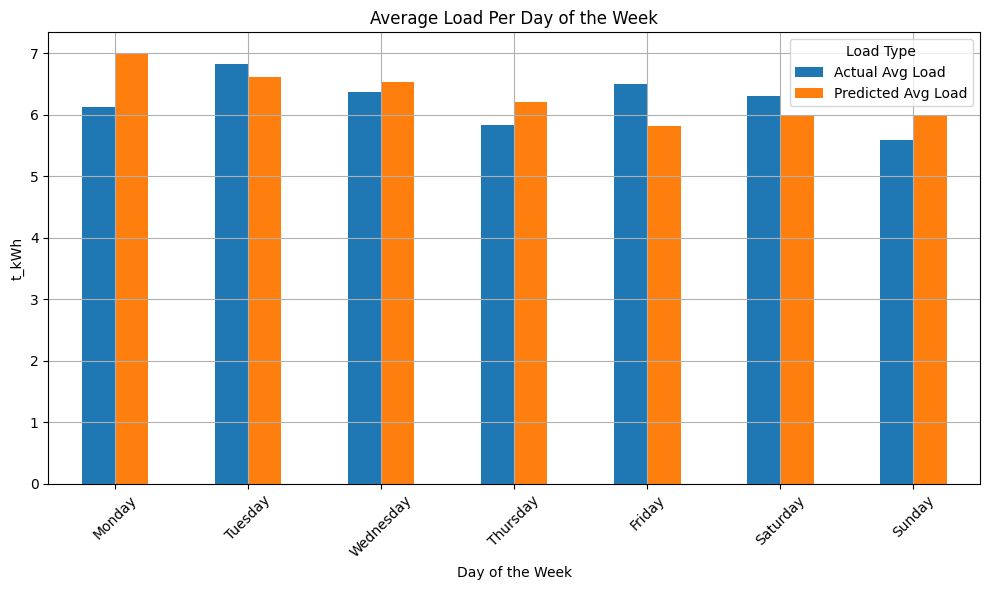

In [389]:
table_and_plots(dates_test,y_test,y_test_pred)
y_test_pred_catboost=y_test_pred

# FFNN

Training Progress:   0%| | 0/5000 [00:00<?, ?it/s, Train Loss=0.874, Val Loss=0.

Training Progress:  13%|▏| 658/5000 [00:01<00:09, 475.27it/s, Train Loss=0.189, 


Early stopping triggered.
Metric      Train       Test        
------------------------------------
RMSE        1.0303      0.8531      
MAE         0.6785      0.7065      
R2          0.8852      0.5149      


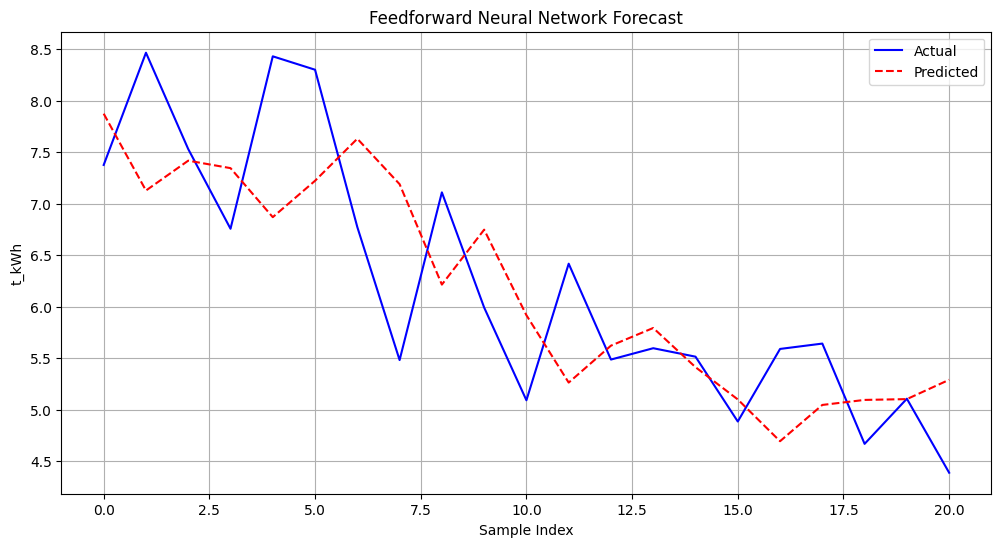

In [390]:
# Import required libraries
from sklearn.preprocessing import StandardScaler

# Set seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Standardize features (X)
scaler_X = StandardScaler()
X_train_fit = scaler_X.fit_transform(X_train)
X_test_fit = scaler_X.transform(X_test)

# Standardize target (y)
scaler_y = StandardScaler()
y_train_fit = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_fit = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_fit, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_fit, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_fit, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_fit, dtype=torch.float32)

# Define Feedforward Neural Network
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 28)  # Input layer
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)    # Add dropout
        self.fc2 = nn.Linear(28, 14)         # Hidden layer
        self.dropout2 = nn.Dropout(p=0.2)    # Add dropout
        self.fc3 = nn.Linear(14, 7)          # Output layer
        self.dropout3 = nn.Dropout(p=0.2)    # Add dropout
        self.fc4 = nn.Linear(7, 1)          # Output layer
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)                # Apply dropout
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)                # Apply dropout
        x = self.fc3(x)
        x = self.dropout3(x)                # Apply dropout
        x = self.fc4(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = FeedForwardNN(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add L2 regularization (weight_decay)

# Training with Early Stopping
num_epochs = 5000
patience = 500  # Early stopping patience
best_val_loss = float('inf')
early_stop_counter = 0

# Initialize tqdm progress bar for epochs
progress_bar = tqdm(range(num_epochs), desc="Training Progress", ncols=80)

for epoch in progress_bar:
    model.train()  # Ensure the model is in training mode
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor.unsqueeze(1))  # Match dimensions for MSELoss

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Evaluate on the validation set (test set in this case for simplicity)
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_tensor)
        val_loss = criterion(y_val_pred, y_test_tensor.unsqueeze(1))

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            progress_bar.write("Early stopping triggered.")
            break

    # Update progress bar with current losses
    progress_bar.set_postfix({"Train Loss": loss.item(), "Val Loss": val_loss.item()})

# Final evaluation
model.eval()
y_train_pred = model(X_train_tensor).detach().numpy()
y_test_pred = model(X_test_tensor).detach().numpy()

# Rescale predictions to the original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train_fit.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test_fit.reshape(-1, 1))

# Function to calculate metrics
metrics(y_train_rescaled, y_test_rescaled, y_train_pred_rescaled, y_test_pred_rescaled)

# Plot actual vs predicted values for test set
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual', color='blue')
plt.plot(range(len(y_test_pred_rescaled)), y_test_pred_rescaled, label='Predicted', color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('t_kWh')
plt.title('Feedforward Neural Network Forecast')
plt.legend()
plt.grid(True)
plt.show()





/tmp/ipykernel_1109064/964526536.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_day = results_df.groupby('day_of_week').apply(


Average Load Per Day with Metrics:
             Actual Avg Load  Predicted Avg Load      RMSE       MAE       MAPE
day_of_week                                                                    
Monday              6.124000            6.824760  1.028062  0.768734  13.242621
Tuesday             6.819667            6.147131  0.937056  0.815361  10.922841
Wednesday           6.370333            6.286188  0.679326  0.587580  10.036752
Thursday            5.830000            6.102680  0.678574  0.669592  11.821503
Friday              6.505000            5.742483  1.147071  1.046770  15.206812
Saturday            6.297667            5.982279  0.626873  0.405352   5.171556
Sunday              5.586000            6.237877  0.727326  0.651877  12.238677


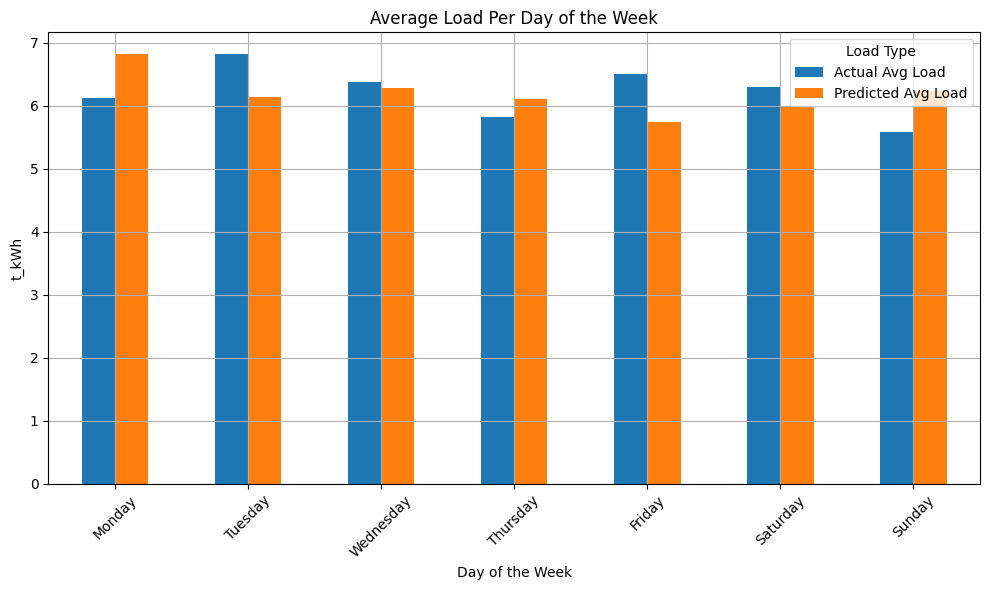

In [391]:
y_test_pred = np.array(y_test_pred_rescaled).flatten()
table_and_plots(dates_test,y_test,y_test_pred)
y_test_pred_ffnn=y_test_pred

# Time-Aware LSTM

/mnt/External/8TBHDD/AAG/EDA/eda_aag/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
Training Progress:  11%| | 574/5000 [00:03<00:23, 186.19it/s, Train Loss=0.0427,


Early stopping triggered.
Metric      Train       Test        
------------------------------------
RMSE        0.5063      0.8653      
MAE         0.3748      0.6203      
R2          0.9723      0.5009      


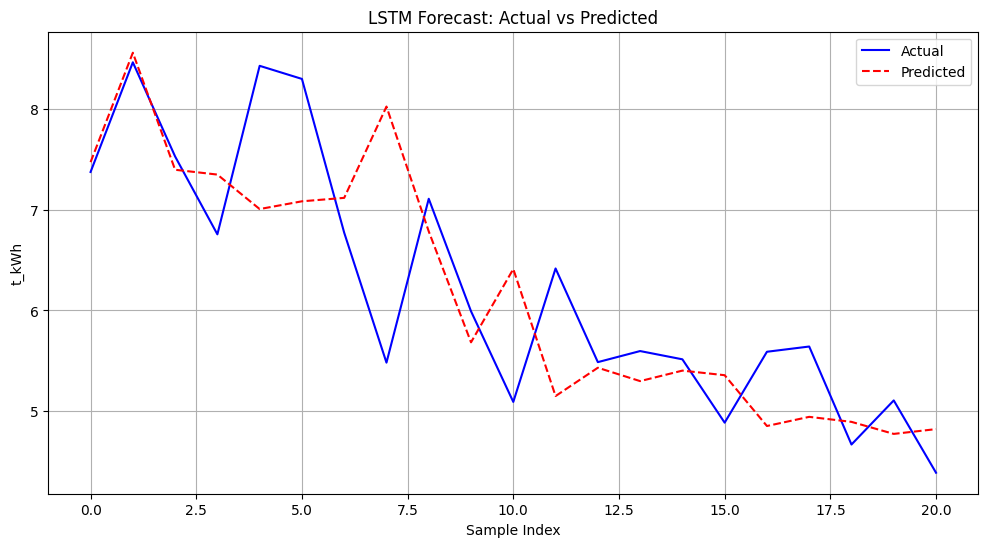

In [392]:
from sklearn.preprocessing import StandardScaler

# Set seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Standardize features (X)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Standardize target (y)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).view(-1, 1, X_train.shape[1])  # (batch, seq_len=1, input_dim)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).view(-1, 1, X_test.shape[1])
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

# Define the LSTM Model
class TimeAwareLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super(TimeAwareLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Stacked LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

        # Activation functions
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # Initialize hidden and cell states for stacked LSTM
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h_0, c_0))

        # Pass the output through fully connected layers
        out = self.fc1(self.dropout(out[:, -1, :]))
        out = self.relu(out)
        out = self.fc2(self.dropout(out))
        return out

# Initialize model, loss, and optimizer
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 1
num_layers = 1  # Adding more layers
model = TimeAwareLSTM(input_dim, hidden_dim, output_dim, num_layers=num_layers, dropout=0.1)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training Loop with tqdm and Early Stopping
num_epochs = 5000
patience = 500  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Track the best validation loss
early_stop_counter = 0  # Counter for early stopping

progress_bar = tqdm(range(num_epochs), desc="Training Progress", ncols=80)

for epoch in progress_bar:
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)

    # Check for improvement in validation loss
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        early_stop_counter = 0  # Reset counter if validation loss improves
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            progress_bar.write("Early stopping triggered.")
            break

    # Update tqdm progress bar
    progress_bar.set_postfix({"Train Loss": train_loss.item(), "Val Loss": val_loss.item()})

# Final Evaluation
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).detach().numpy()
    y_test_pred = model(X_test_tensor).detach().numpy()

# Rescale predictions to the original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

# Calculate evaluation metrics
metrics(y_train_rescaled, y_test_rescaled, y_train_pred_rescaled, y_test_pred_rescaled)

# Plot actual vs predicted values for test set
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual', color='blue')
plt.plot(range(len(y_test_pred_rescaled)), y_test_pred_rescaled, label='Predicted', color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('t_kWh')
plt.title('LSTM Forecast: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()



/tmp/ipykernel_1109064/964526536.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_day = results_df.groupby('day_of_week').apply(


Average Load Per Day with Metrics:
             Actual Avg Load  Predicted Avg Load      RMSE       MAE       MAPE
day_of_week                                                                    
Monday              6.124000            6.966652  1.470448  0.917479  16.579709
Tuesday             6.819667            6.900456  0.334703  0.296771   5.108537
Wednesday           6.370333            5.977840  0.467568  0.392493   6.695199
Thursday            5.830000            6.234756  0.927368  0.870260  15.688681
Friday              6.505000            5.683665  1.107227  0.971294  13.810409
Saturday            6.297667            5.763247  0.728082  0.534420   7.388751
Sunday              5.586000            5.746164  0.363415  0.359124   6.768463


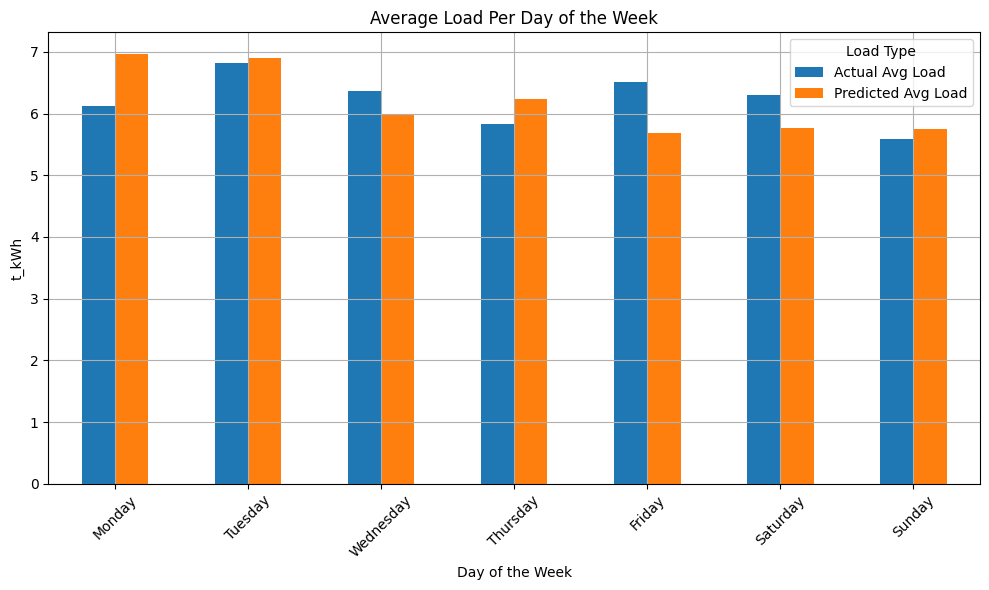

In [393]:
y_test_pred = np.array(y_test_pred_rescaled).flatten()
table_and_plots(dates_test,y_test,y_test_pred)
y_test_pred_tlstm=y_test_pred

# GRU

GRU Training Progress:   2%|    | 116/5000 [00:00<00:22, 219.75it/s, Loss=0.173]

GRU Training Progress:  11%|▏ | 572/5000 [00:02<00:20, 220.09it/s, Loss=0.00812]


Early stopping triggered.
Metric      Train       Test        
------------------------------------
RMSE        0.2758      1.0982      
MAE         0.1966      0.8005      
R2          0.9918      0.1961      


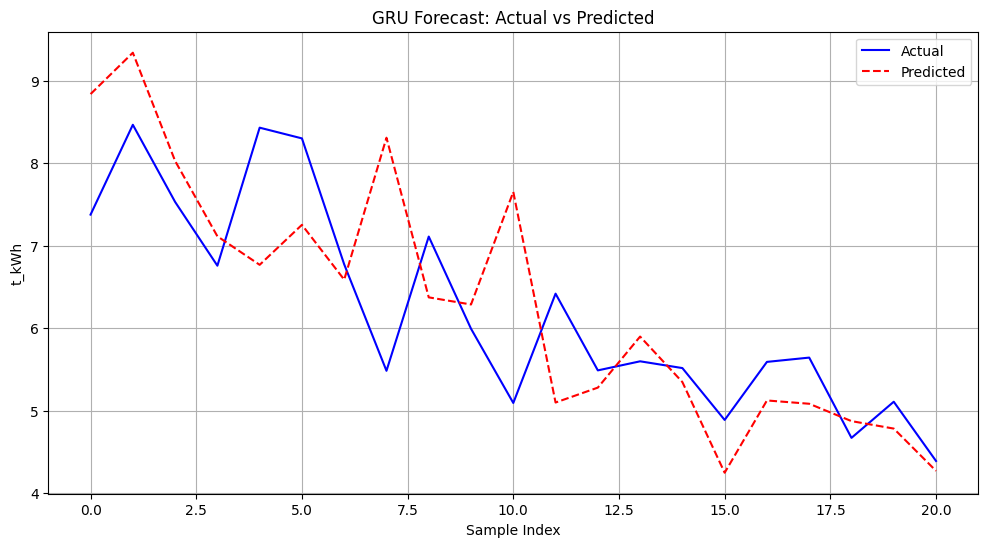

In [394]:
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Standardize features (X)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Standardize target (y)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).view(-1, 1, X_train.shape[1])
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).view(-1, 1, X_test.shape[1])
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

# Define the GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Initialize GRU model
input_dim = X_train.shape[1]
hidden_dim = 64
num_layers = 2
output_dim = 1
gru_model = GRUModel(input_dim, hidden_dim, num_layers, output_dim)
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training Loop for GRU without Batch Processing and Early Stopping
num_epochs = 5000
patience = 500
best_val_loss = float('inf')
early_stop_counter = 0
progress_bar = tqdm(range(num_epochs), desc="GRU Training Progress", ncols=80)

for epoch in progress_bar:
    gru_model.train()

    # Forward pass
    predictions = gru_model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update tqdm progress bar
    progress_bar.set_postfix({"Loss": loss.item()})

    # Early Stopping Check
    gru_model.eval()
    with torch.no_grad():
        val_predictions = gru_model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            progress_bar.write("Early stopping triggered.")
            break

# Use the GRU model for prediction
gru_model.eval()
with torch.no_grad():
    y_train_pred = gru_model(X_train_tensor).detach().numpy()
    y_test_pred = gru_model(X_test_tensor).detach().numpy()

# Rescale predictions to the original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_rescaled = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

# Calculate evaluation metrics
metrics(y_train_rescaled, y_test_rescaled, y_train_pred_rescaled, y_test_pred_rescaled)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual', color='blue')
plt.plot(range(len(y_test_pred_rescaled)), y_test_pred_rescaled, label='Predicted', color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('t_kWh')
plt.title('GRU Forecast: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_1109064/964526536.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_day = results_df.groupby('day_of_week').apply(


Average Load Per Day with Metrics:
             Actual Avg Load  Predicted Avg Load      RMSE       MAE       MAPE
day_of_week                                                                    
Monday              6.124000            7.496263  1.838947  1.485327  24.807705
Tuesday             6.819667            6.652058  0.756009  0.749893  11.256980
Wednesday           6.370333            6.477931  0.428791  0.419331   6.621251
Thursday            5.830000            6.614985  1.525738  1.157996  21.809722
Friday              6.505000            5.578651  1.231097  1.061769  14.879689
Saturday            6.297667            5.770360  0.644770  0.527306   7.600588
Sunday              5.586000            5.584296  0.214935  0.201640   3.607794


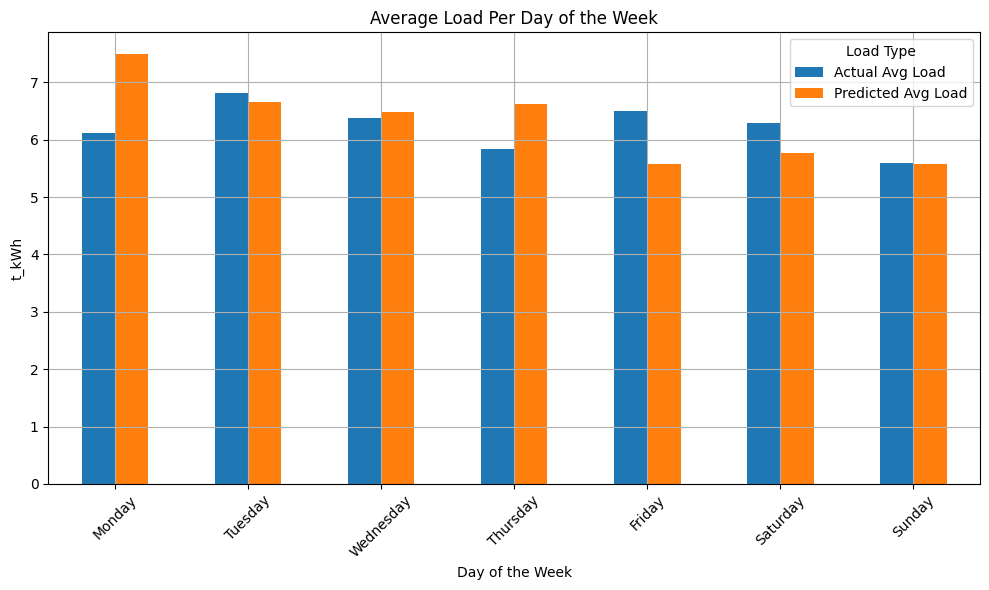

In [395]:
y_test_pred = np.array(y_test_pred_rescaled).flatten()
table_and_plots(dates_test,y_test,y_test_pred)
y_test_pred_gru=y_test_pred

# FInal Comparisons

/tmp/ipykernel_1109064/3167877215.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_load_per_day = df_comparison.groupby('day_of_week')[['actual', 'xgboost', 'Lightgbm', 'catboost', 'FFNN', 'tlstm', 'gru']].mean()


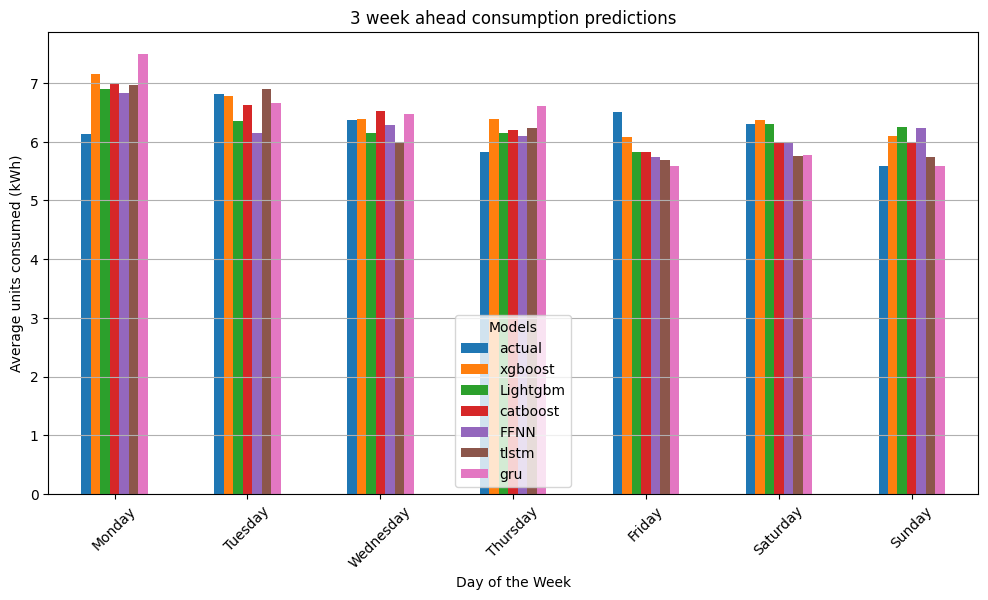

In [396]:
# Create DataFrame for comparison
df_comparison = pd.DataFrame({
    'date': dates_test,
    'actual': y_test,
    'xgboost':y_test_pred_xg,
    'Lightgbm':y_test_pred_lightgbm,
    'catboost':y_test_pred_catboost,
    'FFNN':y_test_pred_ffnn,
    'tlstm': y_test_pred_tlstm,
    'gru': y_test_pred_gru
})

# Add day of the week column
df_comparison['day_of_week'] = pd.Categorical(df_comparison['date'].dt.day_name(),
                                              categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                              ordered=True)

# Calculate average load predictions for each day of the week
avg_load_per_day = df_comparison.groupby('day_of_week')[['actual', 'xgboost', 'Lightgbm', 'catboost', 'FFNN', 'tlstm', 'gru']].mean()

# Plot bar chart for comparison
avg_load_per_day.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Day of the Week')
plt.ylabel('Average units consumed (kWh)')
plt.title('3 week ahead consumption predictions')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Models', loc='lower center')
plt.show()